In [1]:
experiment_name= "KaggleFashion_pretrain_classification_resnet34"

In [2]:
import glob
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
from pandas.core.common import flatten
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

from datasets import *
import networks
import utils


import ast
import PIL


In [3]:
#######################################################
#                  Create Dataset
#######################################################
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

#######################################################
#                  Create Dataset
#######################################################
# dataset_train = datasets.FashionProductsDataset(img_dir="./images",train_path="DeepFashionDataset_train.csv",mode="train", transform= transform)
dataset_train = FashionProductsDataset(img_dir="./Kaggle_fashion/images", styles_dir="./Kaggle_fashion/styles.csv")

/tmp/ipykernel_9116/161129884.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  dataset_train = FashionProductsDataset(img_dir="./Kaggle_fashion/images", styles_dir="./Kaggle_fashion/styles.csv")
/tmp/ipykernel_9116/161129884.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  dataset_train = FashionProductsDataset(img_dir="./Kaggle_fashion/images", styles_dir="./Kaggle_fashion/styles.csv")


In [4]:
len(dataset_train)

44419

In [5]:
dataset_train.classes_set

['Apparel/Topwear',
 'Apparel/Bottomwear',
 'Accessories/Watches',
 'Accessories/Socks',
 'Footwear/Shoes',
 'Accessories/Belts',
 'Footwear/Flip Flops',
 'Accessories/Bags',
 'Apparel/Innerwear',
 'Footwear/Sandal',
 'Accessories/Shoe Accessories',
 'Personal Care/Fragrance',
 'Accessories/Jewellery',
 'Personal Care/Lips',
 'Apparel/Saree',
 'Accessories/Eyewear',
 'Personal Care/Nails',
 'Accessories/Scarves',
 'Apparel/Dress',
 'Apparel/Loungewear and Nightwear',
 'Accessories/Wallets',
 'Apparel/Apparel Set',
 'Accessories/Headwear',
 'Accessories/Mufflers',
 'Personal Care/Skin Care',
 'Personal Care/Makeup',
 'Free Items/Free Gifts',
 'Accessories/Ties',
 'Accessories/Accessories',
 'Personal Care/Skin',
 'Personal Care/Beauty Accessories',
 'Accessories/Water Bottle',
 'Personal Care/Eyes',
 'Personal Care/Bath and Body',
 'Accessories/Gloves',
 'Accessories/Sports Accessories',
 'Accessories/Cufflinks',
 'Sporting Goods/Sports Equipment',
 'Accessories/Stoles',
 'Personal Care

In [6]:
len(dataset_train.classes_set)

47

In [7]:
dataset_train.classes[:5]

['Apparel/Topwear',
 'Apparel/Bottomwear',
 'Accessories/Watches',
 'Apparel/Bottomwear',
 'Apparel/Topwear']

/home/ayla/Desktop/DeepFashion_Consumer-to-shop Clothes Retrieval Benchmark/datasets.py:74: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img_tensor = torch.from_numpy(np.asarray(image))


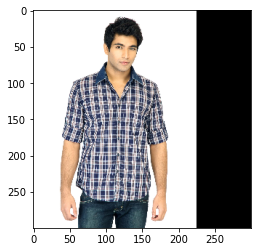

In [8]:
import matplotlib.pyplot as plt 
plt.imshow(dataset_train.__getitem__(0)[0].permute(1, 2, 0) )

### # Create valid data set:

In [33]:
from torch.utils.data.sampler import SubsetRandomSampler
# percentage of training set to use as validation
valid_size = 0.3

# obtain training indices that will be used for validation
num_train= len(dataset_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [34]:
batch_size= 4
# number of subprocesses to use for data loading
num_workers = 0

# prepare data loaders:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [35]:
# Visualize some sample data
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

In [36]:
images.shape

(4, 3, 300, 300)

In [37]:
labels.shape

torch.Size([4])

In [38]:
labels

tensor([4, 8, 4, 4])

In [39]:
print([dataset_train.classes_set[i.item()] for i in labels ])

['Footwear/Shoes', 'Apparel/Innerwear', 'Footwear/Shoes', 'Footwear/Shoes']


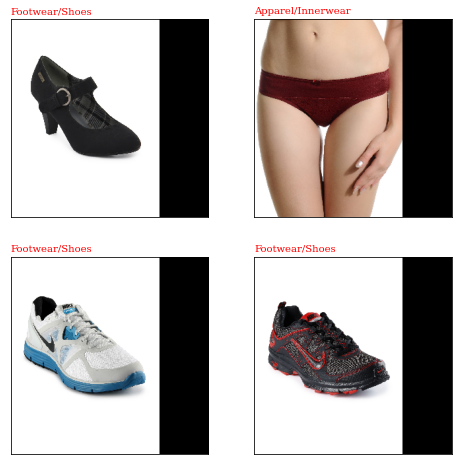

In [40]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(dataset_train.classes_set[labels[idx].item()], fontfamily='serif', loc='left', fontsize='medium', color= 'red')

In [41]:
# check if CUDA is available
cuda = torch.cuda.is_available()

if not cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [42]:
train_loader.dataset.classes_set

['Apparel/Topwear',
 'Apparel/Bottomwear',
 'Accessories/Watches',
 'Accessories/Socks',
 'Footwear/Shoes',
 'Accessories/Belts',
 'Footwear/Flip Flops',
 'Accessories/Bags',
 'Apparel/Innerwear',
 'Footwear/Sandal',
 'Accessories/Shoe Accessories',
 'Personal Care/Fragrance',
 'Accessories/Jewellery',
 'Personal Care/Lips',
 'Apparel/Saree',
 'Accessories/Eyewear',
 'Personal Care/Nails',
 'Accessories/Scarves',
 'Apparel/Dress',
 'Apparel/Loungewear and Nightwear',
 'Accessories/Wallets',
 'Apparel/Apparel Set',
 'Accessories/Headwear',
 'Accessories/Mufflers',
 'Personal Care/Skin Care',
 'Personal Care/Makeup',
 'Free Items/Free Gifts',
 'Accessories/Ties',
 'Accessories/Accessories',
 'Personal Care/Skin',
 'Personal Care/Beauty Accessories',
 'Accessories/Water Bottle',
 'Personal Care/Eyes',
 'Personal Care/Bath and Body',
 'Accessories/Gloves',
 'Accessories/Sports Accessories',
 'Accessories/Cufflinks',
 'Sporting Goods/Sports Equipment',
 'Accessories/Stoles',
 'Personal Care

In [43]:
dataset_train.labels

array([ 0,  1,  2, ...,  0, 11,  2])

In [46]:
batch_size= 128
num_workers = 0 # number of subprocesses to use for data loading

# prepare data loaders:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)

In [47]:
# Load the pretrained model from pytorch
embedding_net= torchvision.models.resnet34(pretrained=True)

# print out the model structure
print(embedding_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ayla/anaconda3/envs/fashion/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [49]:
embedding_net.fc= nn.Sequential(nn.Linear(512, 128),
                                nn.BatchNorm1d(128),
                                nn.ReLU(),
                                nn.Linear(128, 47)
                                )

In [50]:
# Un-Freeze training for all layers parameters:
for param in embedding_net.parameters():
    param.required_grad = True    

In [51]:
model= embedding_net

In [52]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [53]:
device = torch.device('cuda')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
def train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda): 
    
    ###################
    # train the model #
    ###################
    model.train()

   # keep track of training loss
    train_loss = 0.0
    train_acc = 0.0
    nbr_class= 47
    class_correct = list(0. for i in range(nbr_class))
    class_total = list(0. for i in range(nbr_class))
    class_acc= list(0. for i in range(nbr_class))
    
    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):

        # data.float():  due to Kaggle fashion item dataset error: RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same
        
        # move tensors to GPU if CUDA is available
        if cuda:
            data, target= data.float().to(device), target.to(device)

        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: create embeddings of the inputs
        outputs = model(data)

        # append targets to the end of the embeddings, and calculate the batch loss
        loss = loss_fn(outputs, target)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() # Assuming lss function returns average loss

        losses.append(loss.item())
        
        
        # convert output probabilities to predicted class
        _, pred = torch.max(outputs, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not cuda else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
            
            
        
        # Provide some feedbach within one epoch
        if batch_idx % log_interval == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses)))
            losses = []

    # calculate accuracy:      
    for i in range(nbr_class):
        if class_total[i] > 0:
            class_acc[i]= 100 * class_correct[i] / class_total[i]
    train_acc= np.average(class_acc)
        
    # calculate average train loss (batch average is returned)
    train_loss /= (batch_idx + 1)
    
    return train_loss, train_acc

In [72]:
def test_epoch(val_loader, model, loss_fn, cuda):
    
    ######################    
    # validate the model #
    ######################
    
    # keep track of validation loss
    valid_loss = 0.0
    valid_acc = 0.0
    
    nbr_class= 47
    class_correct = list(0. for i in range(nbr_class))
    class_total = list(0. for i in range(nbr_class))
    class_acc= list(0. for i in range(nbr_class))
    
    with torch.no_grad():

        model.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            data= data.float() # cast to float
            
            # move tensors to GPU if CUDA is available
            if cuda:
                data, target= data.to(device), target.to(device)

            outputs = model(data)

            loss = loss_fn(outputs, target)
             
            # update average validation loss 
            valid_loss += loss.item()
            
            
            
            
           
            # convert output probabilities to predicted class
            _, pred = torch.max(outputs, 1)    
            # compare predictions to true label
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not cuda else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            for i in range(len(data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

                
        # calculate accuracy:      
        for i in range(nbr_class):
            if class_total[i] > 0:
                class_acc[i]= 100 * class_correct[i] / class_total[i]
        valid_acc= np.average(class_acc)
                
        # calculate average validation loss (assuming batch average is returned)
        valid_loss /= (batch_idx + 1)


    return valid_loss, valid_acc

In [73]:
def save_model(EPOCH, model, optimizer, LOSS): # epoch and loss are numbers
    """
    Save the trained model and the optimizer to disk.
    """      
    torch.save({
                'epoch': EPOCH,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': LOSS,
                }, experiment_name+'.pt')

In [75]:
start_epoch= 0
n_epochs= 100

log_interval=50

train_losses, valid_losses = [], []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(start_epoch, n_epochs):
    
    # keep track of training and validation loss
    train_loss = 0.0
    train_acc = 0.0
    
    valid_loss = 0.0
    valid_acc = 0.0
    
    train_loss, train_acc = train_epoch(train_loader, model, loss_fn, optimizer, log_interval, cuda)
    valid_loss, valid_acc = test_epoch(valid_loader, model, loss_fn, cuda)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: Epoch: {}/{} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
        epoch + 1, n_epochs, train_loss, train_acc, valid_loss, valid_acc))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format( valid_loss_min,
                                                                                          valid_loss))
        save_model(epoch, model, optimizer, train_loss)
        valid_loss_min = valid_loss

Train: [0/44419 (0%)]	Loss: 0.416765
Train: [150/44419 (21%)]	Loss: 0.243014
Train: [300/44419 (41%)]	Loss: 0.240906
Train: [450/44419 (62%)]	Loss: 0.243028
Train: [600/44419 (82%)]	Loss: 0.210381
Epoch: Epoch: 1/100 	Training Loss: 0.229396 	Training Accuracy: 47.788286 	Valid Loss: 0.220002 	Valid Acc: 48.763694
Validation loss decreased (inf --> 0.220002).  Saving model ...
Train: [0/44419 (0%)]	Loss: 0.210863
Train: [150/44419 (21%)]	Loss: 0.161427
Train: [300/44419 (41%)]	Loss: 0.161755
Train: [450/44419 (62%)]	Loss: 0.157461
Train: [600/44419 (82%)]	Loss: 0.170026
Epoch: Epoch: 2/100 	Training Loss: 0.165278 	Training Accuracy: 52.485068 	Valid Loss: 0.405997 	Valid Acc: 43.629841
Train: [0/44419 (0%)]	Loss: 0.110722
Train: [150/44419 (21%)]	Loss: 0.135938
Train: [300/44419 (41%)]	Loss: 0.129309
Train: [450/44419 (62%)]	Loss: 0.144522
Train: [600/44419 (82%)]	Loss: 0.147247
Epoch: Epoch: 3/100 	Training Loss: 0.138422 	Training Accuracy: 55.198224 	Valid Loss: 0.204233 	Valid Acc

Train: [300/44419 (41%)]	Loss: 0.005654
Train: [450/44419 (62%)]	Loss: 0.006179
Train: [600/44419 (82%)]	Loss: 0.002485
Epoch: Epoch: 26/100 	Training Loss: 0.005217 	Training Accuracy: 93.818258 	Valid Loss: 0.209506 	Valid Acc: 69.436557
Train: [0/44419 (0%)]	Loss: 0.000937
Train: [150/44419 (21%)]	Loss: 0.003828
Train: [300/44419 (41%)]	Loss: 0.006437
Train: [450/44419 (62%)]	Loss: 0.006868
Train: [600/44419 (82%)]	Loss: 0.006830
Epoch: Epoch: 27/100 	Training Loss: 0.006644 	Training Accuracy: 95.194533 	Valid Loss: 0.259717 	Valid Acc: 65.776117
Train: [0/44419 (0%)]	Loss: 0.000395
Train: [150/44419 (21%)]	Loss: 0.021342
Train: [300/44419 (41%)]	Loss: 0.036399
Train: [450/44419 (62%)]	Loss: 0.026543
Train: [600/44419 (82%)]	Loss: 0.031071
Epoch: Epoch: 28/100 	Training Loss: 0.028348 	Training Accuracy: 85.902622 	Valid Loss: 0.236043 	Valid Acc: 65.648563
Train: [0/44419 (0%)]	Loss: 0.025885
Train: [150/44419 (21%)]	Loss: 0.013592
Train: [300/44419 (41%)]	Loss: 0.020879
Train: [4

Train: [150/44419 (21%)]	Loss: 0.000810
Train: [300/44419 (41%)]	Loss: 0.000699
Train: [450/44419 (62%)]	Loss: 0.001533
Train: [600/44419 (82%)]	Loss: 0.000445
Epoch: Epoch: 52/100 	Training Loss: 0.001095 	Training Accuracy: 97.730375 	Valid Loss: 0.214261 	Valid Acc: 70.577126
Train: [0/44419 (0%)]	Loss: 0.000226
Train: [150/44419 (21%)]	Loss: 0.000516
Train: [300/44419 (41%)]	Loss: 0.000493
Train: [450/44419 (62%)]	Loss: 0.001105
Train: [600/44419 (82%)]	Loss: 0.001721
Epoch: Epoch: 53/100 	Training Loss: 0.001027 	Training Accuracy: 97.778257 	Valid Loss: 0.216369 	Valid Acc: 72.474492
Train: [0/44419 (0%)]	Loss: 0.000024
Train: [150/44419 (21%)]	Loss: 0.000564
Train: [300/44419 (41%)]	Loss: 0.001291
Train: [450/44419 (62%)]	Loss: 0.000901
Train: [600/44419 (82%)]	Loss: 0.000811
Epoch: Epoch: 54/100 	Training Loss: 0.001168 	Training Accuracy: 97.748366 	Valid Loss: 0.223958 	Valid Acc: 71.357608
Train: [0/44419 (0%)]	Loss: 0.000032
Train: [150/44419 (21%)]	Loss: 0.000715
Train: [3

Train: [0/44419 (0%)]	Loss: 0.005478
Train: [150/44419 (21%)]	Loss: 0.005911
Train: [300/44419 (41%)]	Loss: 0.005818
Train: [450/44419 (62%)]	Loss: 0.003288
Train: [600/44419 (82%)]	Loss: 0.004261
Epoch: Epoch: 78/100 	Training Loss: 0.004934 	Training Accuracy: 94.232982 	Valid Loss: 0.227248 	Valid Acc: 67.264790
Train: [0/44419 (0%)]	Loss: 0.042306
Train: [150/44419 (21%)]	Loss: 0.002947
Train: [300/44419 (41%)]	Loss: 0.005923
Train: [450/44419 (62%)]	Loss: 0.003857
Train: [600/44419 (82%)]	Loss: 0.007725
Epoch: Epoch: 79/100 	Training Loss: 0.005172 	Training Accuracy: 95.496977 	Valid Loss: 0.221968 	Valid Acc: 67.771494
Train: [0/44419 (0%)]	Loss: 0.001496
Train: [150/44419 (21%)]	Loss: 0.001593
Train: [300/44419 (41%)]	Loss: 0.001864
Train: [450/44419 (62%)]	Loss: 0.002753
Train: [600/44419 (82%)]	Loss: 0.002680
Epoch: Epoch: 80/100 	Training Loss: 0.002445 	Training Accuracy: 97.744011 	Valid Loss: 0.221048 	Valid Acc: 68.462911
Train: [0/44419 (0%)]	Loss: 0.000111
Train: [150/

In [81]:
torch.save({
            'epoch': 100,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': 0.025,
            }, experiment_name+'100epoch.pt')

In [82]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

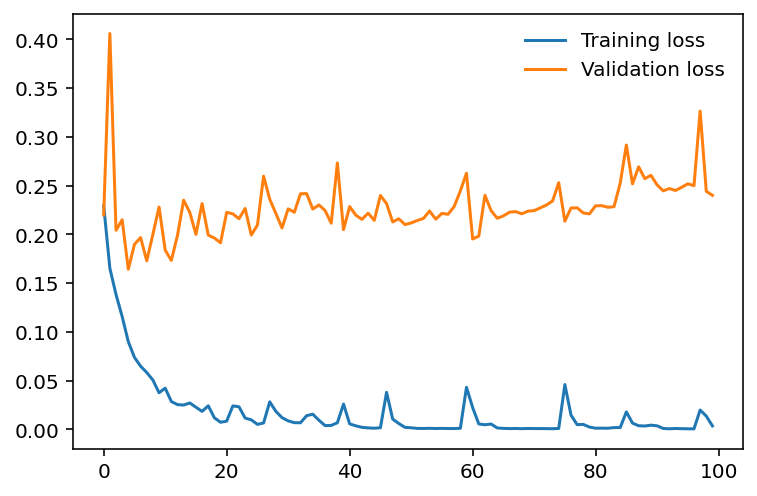

In [83]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

In [84]:
# write training results:
f = open(experiment_name+ "_result"+".csv", "w")
f.write('\t'.join(('tr_er', 'val_er')))
f.write('\n')
for (tr_er, val_er) in zip(train_losses, valid_losses,):
    items= (str(tr_er),',', str(val_er))
    f.write('\t'.join(items))
    f.write('\n')
f.close()